In [1]:
import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from matplotlib import rc 

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.Data load

In [3]:
# 본 개발자는 코랩을 사용하여 이번 셀은 이를 사용하였지만 외부에서 돌리면 에러가 날 수 있습니다. 
input_file = '/content/drive/My Drive/datacam/bike/'

allFile_list = sorted(glob.glob(os.path.join(input_file, 'rent_data_2020_*.csv')))
print(allFile_list)

allData = []

for file in allFile_list:
  df = pd.read_csv(file, encoding='cp949')
  allData.append(df)

['/content/drive/My Drive/datacam/bike/rent_data_2020_01.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_02.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_03.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_04.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_05.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_06.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_07.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_08.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_09.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_10.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_11.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_12.csv']


In [4]:
# 본 개발자는 코랩을 사용하여 이번 셀은 이를 사용하였지만 외부에서 돌리면 에러가 날 수 있습니다. 
dataCombine = pd.concat(allData, axis=0)
bike = dataCombine
bike

,보관소명,년,월,일,요일,시간,대여량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수,지하철_하차인원,구
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727.0,384600.6820,0.0,중랑구
1,(구)신한은행 중랑교지점,2020,1,1,수,1,0,-5.2,0.0,31.0,16.0,74678.0,386599.3398,0.0,중랑구
2,(구)신한은행 중랑교지점,2020,1,1,수,2,0,-5.1,0.0,31.0,16.0,73718.0,388041.4154,0.0,중랑구
3,(구)신한은행 중랑교지점,2020,1,1,수,3,0,-5.3,0.0,31.0,16.0,73376.0,388881.0968,0.0,중랑구
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,-4.8,0.0,31.0,16.0,73378.0,388602.5135,0.0,중랑구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491691,힐스테이트에코,2020,12,31,목,19,2,-6.2,0.0,27.0,10.0,156311.0,534962.2667,0.0,강서구
1491692,힐스테이트에코,2020,12,31,목,20,0,-6.5,0.0,27.0,10.0,152987.0,539474.7866,0.0,강서구
1491693,힐스테이트에코,2020,12,31,목,21,3,-6.2,0.0,27.0,10.0,147288.0,542663.5689,0.0,강서구
1491694,힐스테이트에코,2020,12,31,목,22,1,-6.4,0.0,27.0,10.0,144520.0,544189.3726,0.0,강서구


In [1]:
# 여기서부터 실행하십시오
import pandas as pd
bike = pd.DataFrame()
for mon in range(1,13):
    if mon < 10:
        rent = pd.read_csv('rent_last_2020'+'0'+ str(mon) + '.csv', encoding='cp949')
        bike = pd.concat([bike,rent])
    elif mon >= 10:
        rent = pd.read_csv('rent_last_2020'+ str(mon) + '.csv', encoding='cp949')
        bike = pd.concat([bike,rent])
        
bike


,보관소명,구,년,월,일,요일,시간,대여량,기온,강수,미세먼지,초미세먼지,총유입인구,총생활인구,지하철_하차인원
0,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727,384600,0.0
1,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,1,0,-5.2,0.0,31.0,16.0,74678,386599,0.0
2,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,2,0,-5.1,0.0,31.0,16.0,73718,388041,0.0
3,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,3,0,-5.3,0.0,31.0,16.0,73376,388881,0.0
4,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,4,0,-4.8,0.0,31.0,16.0,73378,388602,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473665,힐스테이트에코,강서구,2020,12,30,수,19,1,-10.7,0.0,31.0,12.0,155477,537841,0.0
1473666,힐스테이트에코,강서구,2020,12,30,수,20,1,-11.3,0.0,31.0,12.0,151656,543161,0.0
1473667,힐스테이트에코,강서구,2020,12,30,수,21,1,-11.8,0.0,31.0,12.0,146137,548354,0.0
1473668,힐스테이트에코,강서구,2020,12,30,수,22,0,-11.8,0.0,31.0,12.0,143574,551912,0.0


## 2.Preprocessing

In [48]:
def convert_df(df):
  df['time'] = time_date(df)
  df = df.reindex(columns=['보관소명', '년', '월', '일', '요일', '시간', '기온', '강수', 
                          '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', '총생활인구수', '지하철_하차인원', '대여량', 'time'])
  df = df.join(pd.get_dummies(df['요일'], prefix="요일"))
  rent_df = df[['time', '대여량']]
  convert_df = df.drop(['보관소명','년','time', '요일'], axis=1)
  return convert_df, rent_df

In [49]:
def time_date(df):
  
  time = []
  length = len(df['보관소명'])

  for i in range(length):
    yyyy = df['년'][i]
    mm = df['월'][i]
    dd = df['일'][i]
    tt = df['시간'][i]
    time.append((datetime.datetime(yyyy,mm,dd,tt)).strftime('%Y-%m-%d %H:%M:%S'))

  return time

In [50]:
dduk = bike[bike['보관소명'] == '뚝섬유원지역 1번출구 앞']
dduk.reset_index(inplace=True,drop=True)
dduk, rent_df = convert_df(dduk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
df = dduk

## 3.Dataset split

In [52]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

7027 1757


## 4.Scaler

In [53]:
f_columns = ['월', '일', '시간', '기온', '강수', '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', 
              '총생활인구수', '지하철_하차인원', '요일_금', '요일_목',	'요일_수', '요일_월',	'요일_일', '요일_토', '요일_화']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['대여량']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['대여량'] = cnt_transformer.transform(train[['대여량']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['대여량'] = cnt_transformer.transform(test[['대여량']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [10]:
f_columns = ['월', '일', '시간','기온', '강수', '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', 
              '총생활인구수', '지하철_하차인원', '요일_금', '요일_목',	'요일_수', '요일_월',	'요일_일', '요일_토', '요일_화']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['대여량']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['대여량'] = cnt_transformer.transform(train[['대여량']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['대여량'] = cnt_transformer.transform(test[['대여량']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [54]:
def create_dataset(x, y, time_steps=1):
  xs, ys = [], []
  for i in range(len(x) - time_steps):
    v = x.iloc[i:(i+time_steps)].values
    xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(xs), np.array(ys)

In [55]:
window_size = 24

#(samples, window_size, features)
x_train, y_train = create_dataset(train, train['대여량'], window_size)
x_test, y_test = create_dataset(test, test['대여량'], window_size)

print(x_train.shape, y_train.shape)

(7003, 24, 15) (7003,)


In [56]:
x_train.shape[1]

24

In [57]:
x_train.shape[2]

15

In [58]:
x_train

array([[[-1.26282051,  0.1       , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        [-1.43589744,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        [-1.41025641,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-1.15384615,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        [-1.16025641,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        [-1.1474359 ,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.43589744,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        [-1.41025641,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        [-1.42307692,  0.        , -0.125     , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-1.16025641,  0.        , -0.125     , ...,  

## 5.Modeling & Training

In [59]:
model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='sigmoid'),
        Dense(1),
])

In [60]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [61]:
data_path = '/content/drive/My Drive/datacam'

earlystopping = EarlyStopping(monitor='val_loss', patience=20)
filename = os.path.join(data_path, 'rent_checkpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weight_only = True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    shuffle=True,
                    epochs=200,
                    batch_size=32,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
132/132 [==============================] - 7s 38ms/step - loss: 1.2305 - mean_absolute_error: 0.6318 - val_loss: 0.5031 - val_mean_absolute_error: 0.4621

Epoch 00001: val_loss improved from inf to 0.50311, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 2/200
132/132 [==============================] - 4s 34ms/step - loss: 0.5352 - mean_absolute_error: 0.4110 - val_loss: 0.3917 - val_mean_absolute_error: 0.4224

Epoch 00002: val_loss improved from 0.50311 to 0.39172, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 3/200
132/132 [==============================] - 4s 34ms/step - loss: 0.4349 - mean_absolute_error: 0.3757 - val_loss: 0.4142 - val_mean_absolute_error: 0.4320

Epoch 00003: val_loss did not improve from 0.39172
Epoch 4/200
132/132 [==============================] - 5s 34ms/step - loss: 0.3830 - mean_absolute_error: 0.3644 - val_loss: 0.3785 - val_mean_absolute_error: 0.4115

Epoch 00004: val_loss improved from 0.39172 to 0.37849, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 5/200
132/132 [==============================] - 4s 33ms/step - loss: 0.3420 - mean_absolute_error: 0.3479 - val_loss: 0.3809 - val_mean_absolute_error: 0.4176

Epoch 00005: val_loss did not improve from 0.37849
Epoch 6/200
132/132 [==============================] - 4s 34ms/step - loss: 0.3231 - mean_absolute_error: 0.3374 - val_loss: 0.3923 - val_mean_absolute_error: 0.4075

Epoch 00006: val_loss did not improve from 0.37849
Epoch 7/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2974 - mean_absolute_error: 0.3331 - val_loss: 0.4536 - val_mean_absolute_error: 0.4285

Epoch 00007: val_loss did not improve from 0.37849
Epoch 8/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2901 - mean_absolute_error: 0.3227 - val_loss: 0.4221 - val_mean_absolute_error: 0.4097

Epoch 00008: val_loss did not improve from 0.37849
Epoch 9/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2894 - mean_absolute_error: 0.3228 - val_loss: 0.4

INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 13/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2538 - mean_absolute_error: 0.3082 - val_loss: 0.3552 - val_mean_absolute_error: 0.3813

Epoch 00013: val_loss improved from 0.37022 to 0.35518, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 14/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2542 - mean_absolute_error: 0.3048 - val_loss: 0.3557 - val_mean_absolute_error: 0.3894

Epoch 00014: val_loss did not improve from 0.35518
Epoch 15/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2450 - mean_absolute_error: 0.3049 - val_loss: 0.3361 - val_mean_absolute_error: 0.3671

Epoch 00015: val_loss improved from 0.35518 to 0.33605, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 16/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2419 - mean_absolute_error: 0.3012 - val_loss: 0.3509 - val_mean_absolute_error: 0.3833

Epoch 00016: val_loss did not improve from 0.33605
Epoch 17/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2434 - mean_absolute_error: 0.3033 - val_loss: 0.3862 - val_mean_absolute_error: 0.3883

Epoch 00017: val_loss did not improve from 0.33605
Epoch 18/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2256 - mean_absolute_error: 0.2952 - val_loss: 0.3463 - val_mean_absolute_error: 0.3847

Epoch 00018: val_loss did not improve from 0.33605
Epoch 19/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2242 - mean_absolute_error: 0.2916 - val_loss: 0.3562 - val_mean_absolute_error: 0.3805

Epoch 00019: val_loss did not improve from 0.33605
Epoch 20/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2219 - mean_absolute_error: 0.2901 - val_loss

## 6.Visualization

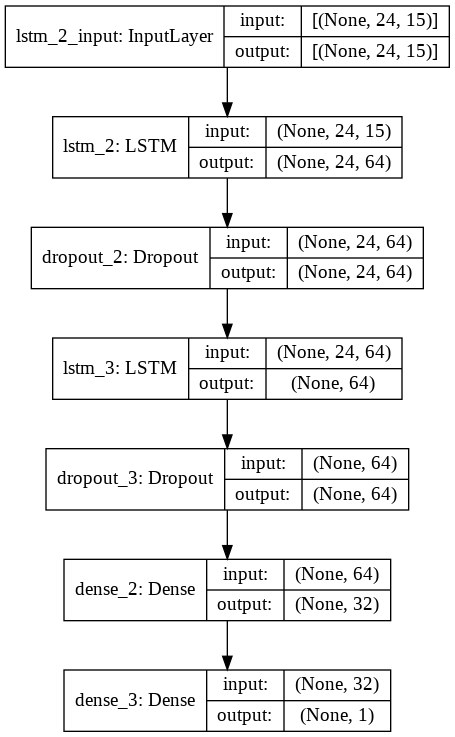

In [62]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

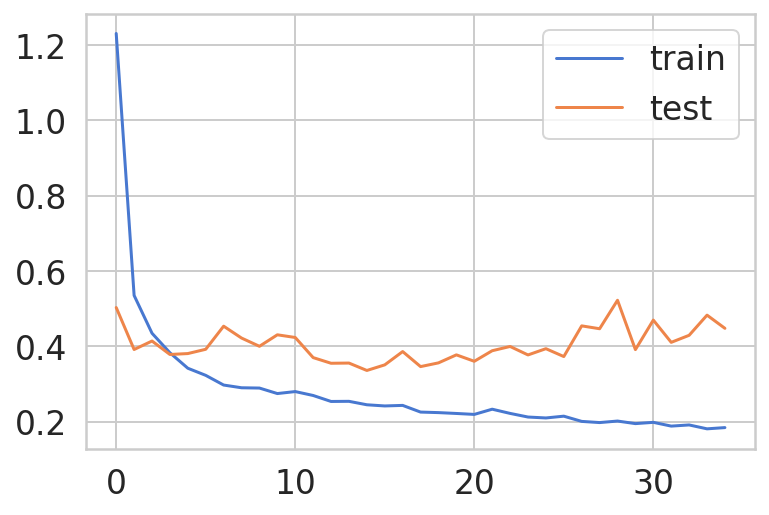

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [64]:
model.load_weights(filename)
y_pred = model.predict(x_test)

In [65]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
#pred_inv = cnt_transformer.inverse_transform(pred)

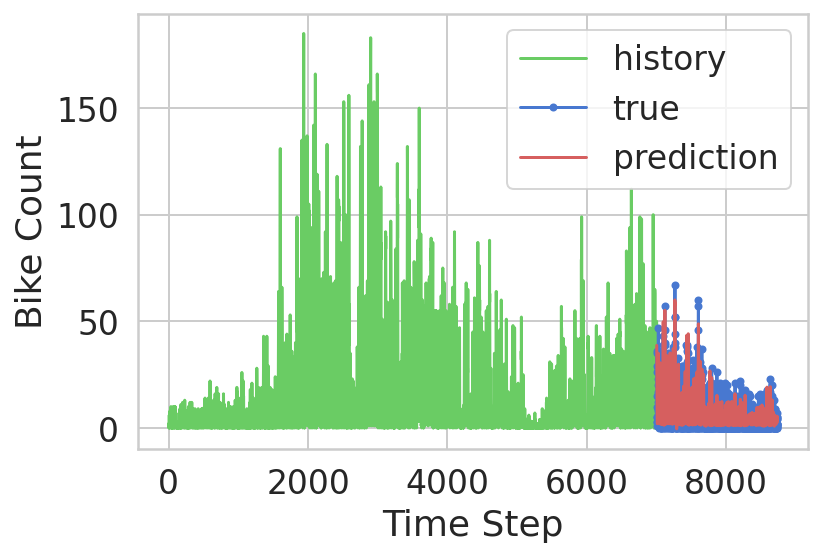

In [66]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

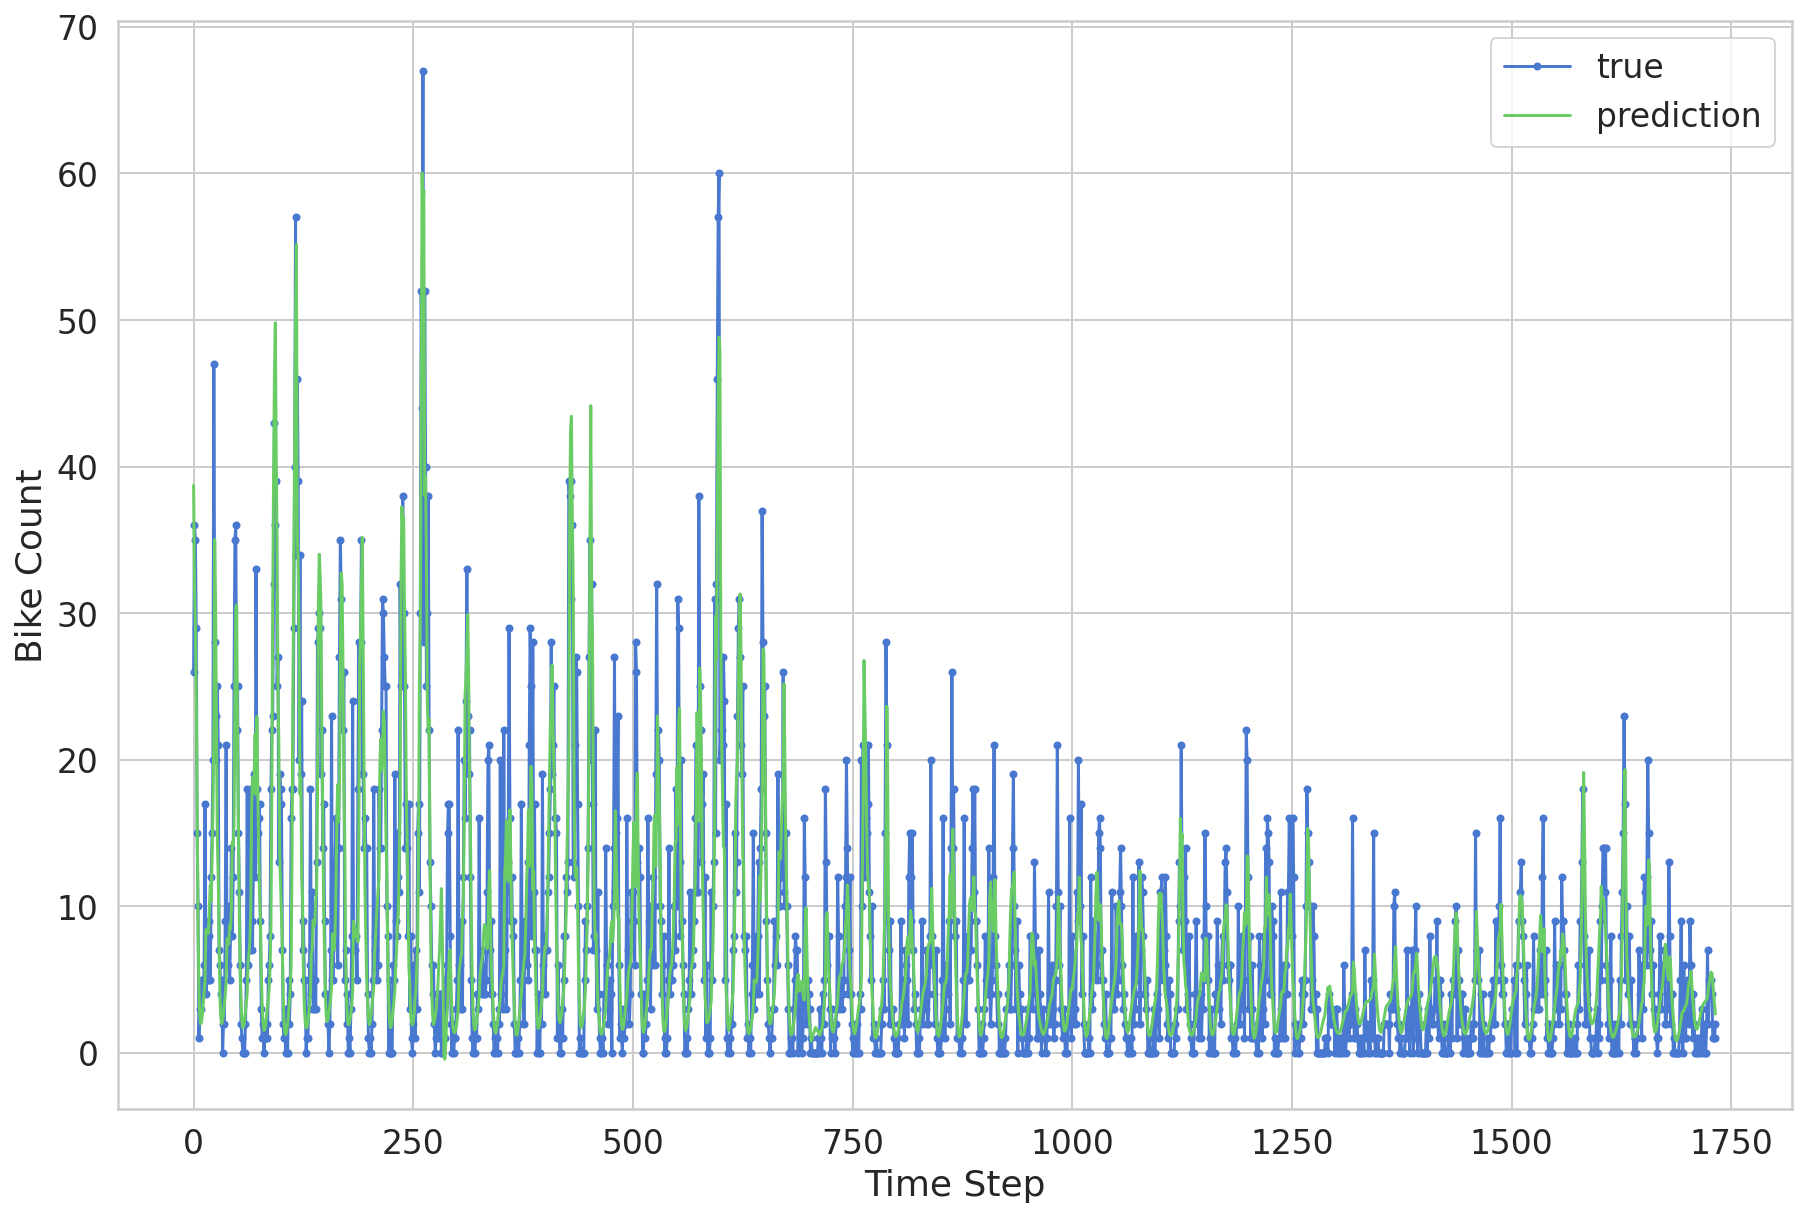

In [67]:
plt.figure(figsize=(15,10))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'g', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

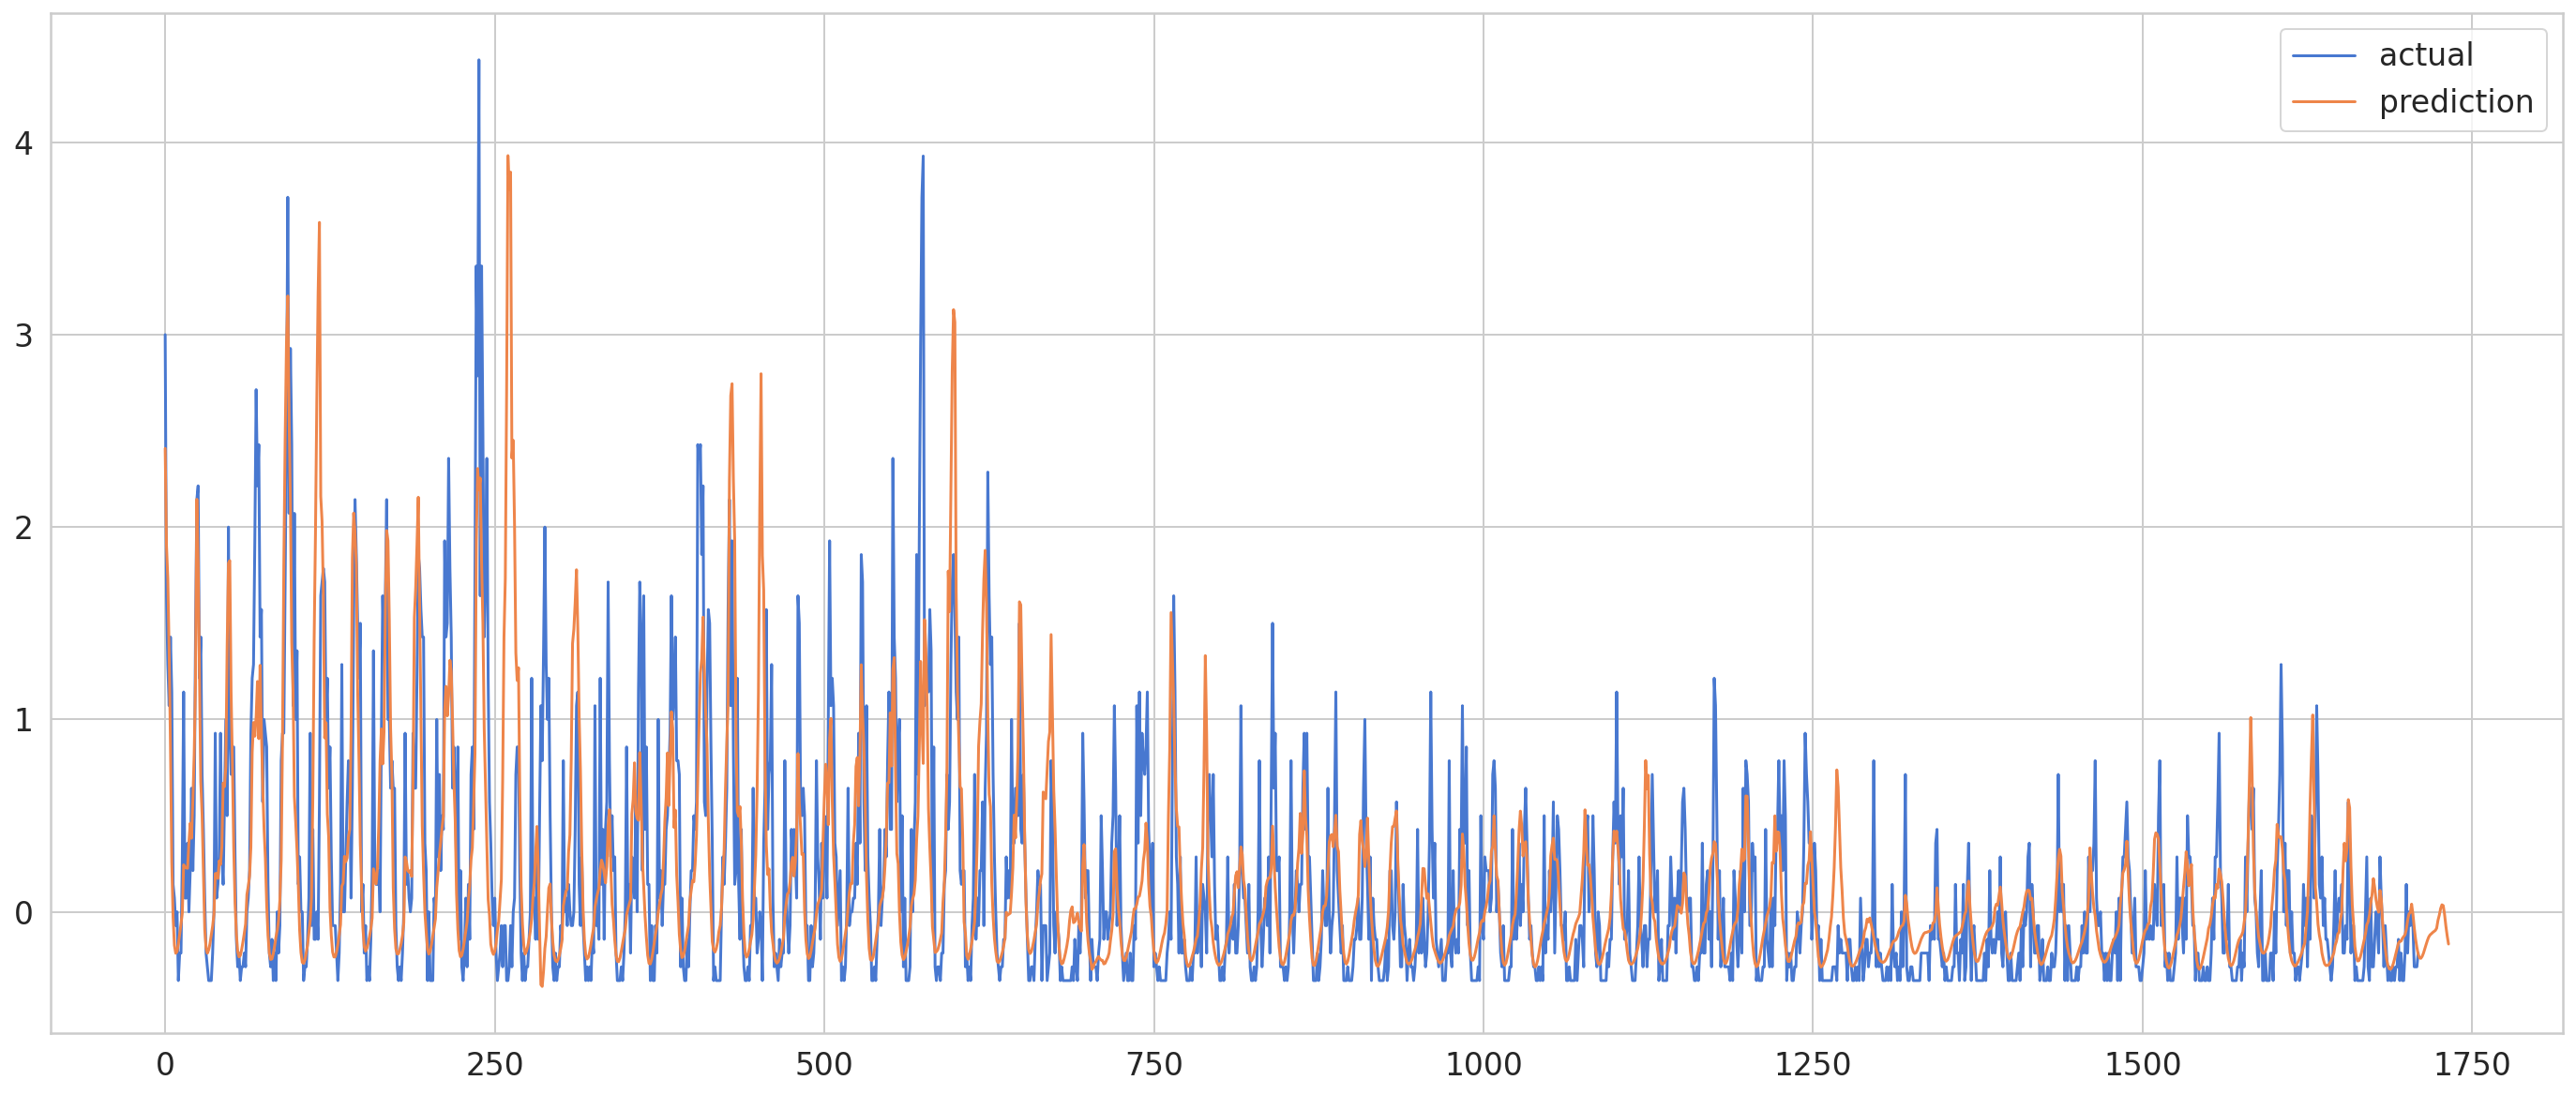

In [68]:
plt.figure(figsize=(24, 10))
plt.plot(np.asarray(y_test)[23:], label='actual')
plt.plot(y_pred[:], label='prediction')
plt.legend()
plt.show()

In [78]:
result = pd.DataFrame(y_pred_inv, columns=['예측값'])
result

,예측값
0,38.724140
1,31.633112
2,29.260115
3,23.992241
4,17.130934
...,...
1728,5.454138
1729,4.818571
1730,3.965837
1731,3.252257


In [79]:
c= []
c = result['예측값']

In [80]:
c = np.around(c)

In [81]:
real = rent_df.iloc[7051:]
real.reset_index(inplace=True, drop=True)
real

,time,대여량
0,2020-10-20 19:00:00,26
1,2020-10-20 20:00:00,36
2,2020-10-20 21:00:00,35
3,2020-10-20 22:00:00,29
4,2020-10-20 23:00:00,15
...,...,...
1728,2020-12-31 19:00:00,4
1729,2020-12-31 20:00:00,1
1730,2020-12-31 21:00:00,1
1731,2020-12-31 22:00:00,1


In [82]:
real.insert(2, '예측값', c)
real

,time,대여량,예측값
0,2020-10-20 19:00:00,26,39.0
1,2020-10-20 20:00:00,36,32.0
2,2020-10-20 21:00:00,35,29.0
3,2020-10-20 22:00:00,29,24.0
4,2020-10-20 23:00:00,15,17.0
...,...,...,...
1728,2020-12-31 19:00:00,4,5.0
1729,2020-12-31 20:00:00,1,5.0
1730,2020-12-31 21:00:00,1,4.0
1731,2020-12-31 22:00:00,1,3.0
